[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/examples/dequantization.ipynb)

If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In addition, uncomment and run the following code:

-------------------
## Dequantization example

Normalizing flows are designed to model continuous variables, however they can be easily adapted to model discrete data as well. This is achieved by inserting a "dequantizer" into the bijector chain. We will demonstrate the use of a Uniform Dequantizer to model checkerboard data.

In [1]:
import jax.numpy as np
from jax import random
from jax.experimental.optimizers import adam
import pandas as pd
import matplotlib.pyplot as plt

from pzflow.bijectors import ShiftBounds, RollingSplineCoupling, Chain, UniformDequantizer
from pzflow.distributions import Uniform
from pzflow import Flow

First let's generate some discrete 2D data in a checkerboard pattern.

In [2]:
N = int(1e5) # number of samples
R = 4 # number of classes, [0, 1, ..., R-1]

# checkerboard data
rng1, rng2 = random.split(random.PRNGKey(0))
x = random.uniform(rng1, maxval=R, shape=(3*N,1)).astype(int)
y = random.uniform(rng2, maxval=R, shape=(3*N,1)).astype(int)
idx = np.where((x % 2) == (y % 2))
data = np.hstack((x, y))[idx[0][:N]]

# save as a Pandas data frame
data = pd.DataFrame(data, columns=("x", "y"))

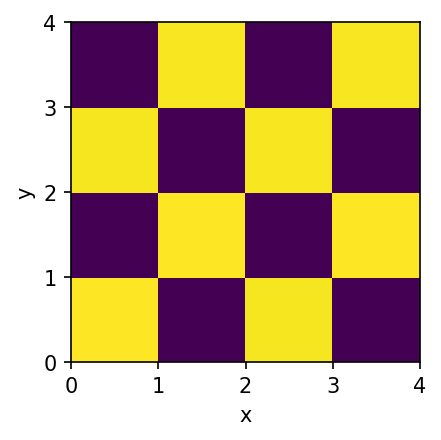

In [3]:
# Let's plot this distribution
fig, ax = plt.subplots(figsize=(3,3), dpi=150)
ax.hist2d(data["x"], data["y"], bins=R, range=((0, R), (0, R)))
ax.set(xlabel="x", ylabel="y", yticks=np.arange(5))
plt.show()

Let's first build a regular normalizing flow to see how it fails to model discrete data.

In [4]:
# construct the flow

bijector = Chain(
    ShiftBounds(0, 4, B=5), # shift bounds of data from (0, 4) -> (-5, 5)
    RollingSplineCoupling(nlayers=2, B=5), # transform distribution
)

latent = Uniform((-5, 5), (-5, 5))

flow = Flow(data.columns, bijector, latent=latent)

In [5]:
%%time

# train the flow

losses = flow.train(data, epochs=35, optimizer=adam(step_size=1e-5))
losses += flow.train(data, epochs=20, optimizer=adam(step_size=1e-6))

CPU times: user 58.4 s, sys: 1min 26s, total: 2min 24s
Wall time: 28.7 s


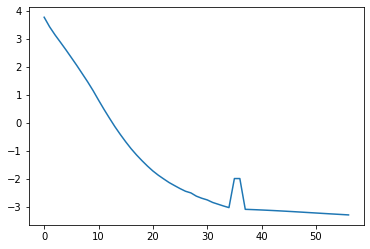

In [6]:
# plot the training losses
plt.plot(losses)

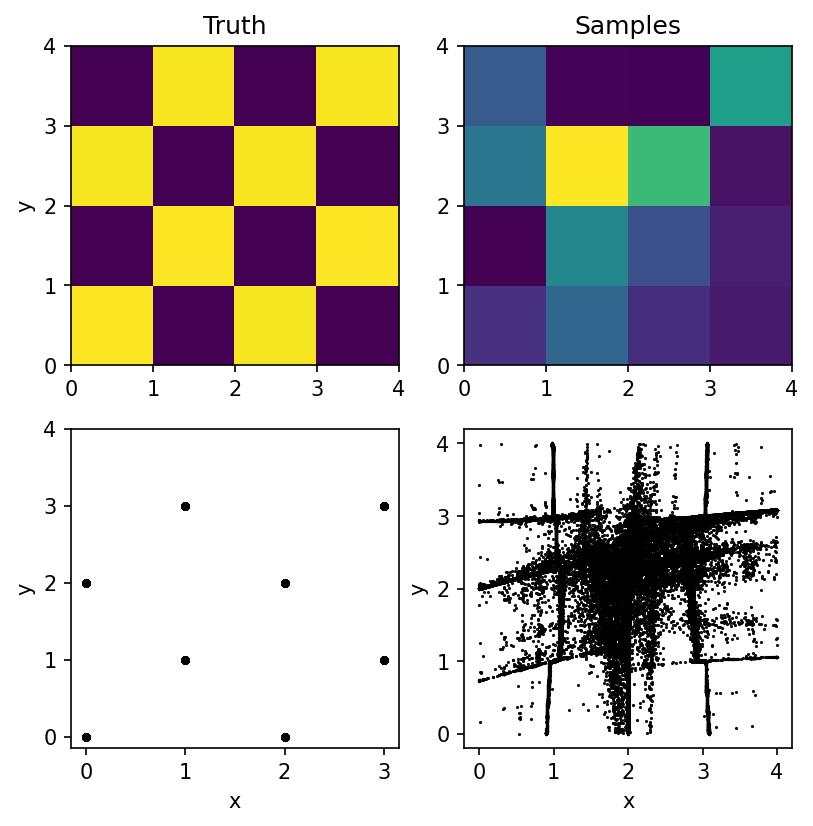

In [7]:
# plot some samples

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6.2, 6.2), dpi=150)

ax1.hist2d(data["x"], data["y"], bins=R, range=((0, R), (0, R)))
ax1.set(ylabel="y", title="Truth", yticks=np.arange(5))
ax3.scatter(data["x"], data["y"], marker=".", c="k")
ax3.set(xlabel="x", ylabel="y", yticks=np.arange(5))

samples = flow.sample(N)
ax2.hist2d(samples["x"], samples["y"], bins=R, range=((0, R), (0, R)))
ax2.set(title="Samples", yticks=np.arange(5))
ax4.scatter(samples["x"], samples["y"], marker=".", c="k", s=1)
ax4.set(xlabel="x", ylabel="y", yticks=np.arange(5))

plt.show()

We can see that this flow doesn't do a good job of modeling the discrete data. Maybe you could do some tweaking and get decent results, however, you can easily get much better results by adding a dequantizer to your bijector chain. Let's demonstrate that below.

In [8]:
# we build the exact same flow, except we add a dequantizer to the bijector chain

bijector = Chain(
    UniformDequantizer(), # dequantize the data
    ShiftBounds(0, 4, B=5), # shift bounds of data from (0, 4) -> (-5, 5)
    RollingSplineCoupling(nlayers=2, B=5), # transform distribution
)

latent = Uniform((-5, 5), (-5, 5))

dq_flow = Flow(data.columns, bijector, latent=latent)

In [9]:
%%time

# train the flow

dq_losses = dq_flow.train(data)

CPU times: user 32.7 s, sys: 1min 15s, total: 1min 48s
Wall time: 18.1 s


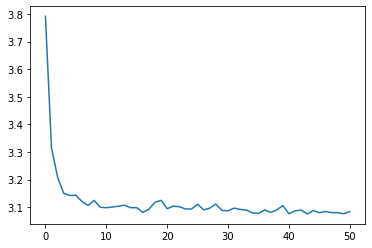

In [10]:
# plot the training losses
plt.plot(dq_losses)

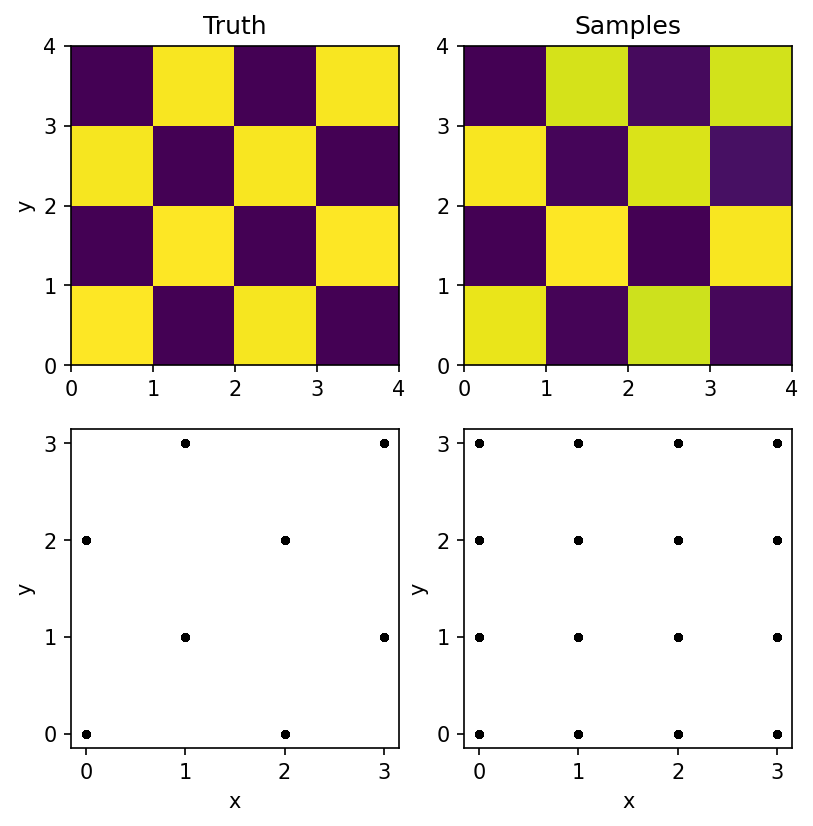

In [11]:
# plot some samples

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6.2, 6.2), dpi=150)

ax1.hist2d(data["x"], data["y"], bins=R, range=((0, R), (0, R)))
ax1.set(ylabel="y", title="Truth", yticks=np.arange(5))
ax3.scatter(data["x"], data["y"], marker=".", c="k")
ax3.set(xlabel="x", ylabel="y", yticks=np.arange(4))

dq_samples = dq_flow.sample(N)
ax2.hist2d(dq_samples["x"], dq_samples["y"], bins=R, range=((0, R), (0, R)))
ax2.set(title="Samples", yticks=np.arange(5))
ax4.scatter(dq_samples["x"], dq_samples["y"], marker=".", c="k")
ax4.set(xlabel="x", ylabel="y", yticks=np.arange(4))

plt.show()

We can see that this flow produces only discrete samples that lie on the grid, and that the distribution of samples closely matches that of the training data. In addition, the training was a lot easier - we could just do a single round of training with default settings, rather than needing to adjust the learning rate schedule. 

One more thing - You can model discrete and continuous variables side-by-side in the same normalizing flow! Just drop in `UniformDequantizer` with `column_idx` equal to the list of column indices corresponding to the discrete variables. 

For example, suppose we want to model data with column names ["a", "b", "c", "d"], and that "a" and "c" are continuous variables, while "b" and "d" are discrete variables. We can use a bijector like this:
```
bijector = Chain(
    UniformDequantizer(column_idx=[1, 3]),
    ...,
)
```